This is notebook demonstrates what we dub "spatial denoising" because it is done using only *one* image at a time. The goal of all these notebooks is to leverage the temporal dimension too, so this notebook is both to compare the results of this approach as well as to introduce some generic tools that are used in the more complex setting.

A brief overview of the theory from our limited vantage point is the following:

[1] Dias and Figueiredo. ["Multiplicative Noise Removal Using Variable Splitting and Constrained Optimization"](https://arxiv.org/pdf/0912.1845.pdf) (2010). Proposes the use of TV regularization for SAR denoising problems shortly after split-bregman optimization is used for TV problems.

[2] Chan et al. ["Plug-and-Play ADMM for Image Restoration: Fixed Point Convergence and Applications
"](https://arxiv.org/abs/1605.01710) (2016). Generalizes the approach from [1] for other regularizers and noise models.

[3] Deledalle et al. ["MuLoG: MUlti-channel LOgarithm with Gaussian denoising"](https://www.charles-deledalle.fr/pages/mulog.php). Proposes a more sophisticated de-speckling algorithm for multi-channel backscatter image using the full covariance matrix. Paper details the algorithm from [1] and [2] for single channel backscatter images as well as the noise models relevant for SAR de-speckling.

We also used the following [repository](https://github.com/WeiyingZhao/Multitemporal-SAR-image-denoising) for reference. They refere to the spatial denoising algorithm as "Molog.m".

### Notes

+ Spatial denoising here is again done 1 polarization at a time. The multitemporal setup requires this so for a comparison, we follow this approach.
+ We have `tv` and `bm3d` as implemented regularizers. We only use `bm3d` for small images because it takes significantly longer to run. To use the later regularizer on large areas it would likely require per-tile application and than an interpolation along borders. One possible way to handle this would be [this](https://docs.dask.org/en/latest/array-overlap.html), but is currently beyond the scope of this notebook. Other approaches would be to run fewer ADMM iterations. The TV regularized de-speckling will generally be much faster and on our machine took less than a few minutes.
+ On the machine this notebook was written and tested, we have ample RAM resources, so we opened all the files (large areas and various polarizations), processed them (filling in nodata areas and then despeckling), and then wrote them to disk. Our approach roughly is:

     ```
     data = [open_one(paths) for path in path_list]
     processed_data = [process_one(img) for img in data]
     dest_paths = [write_one(img) for img in processed_data]
     ```
     
     On machines where such resources are not available, one may have to combine these steps and writing intermediate steps to disk and we currently leave that to the user. What would have to change would be something like this:
     
     ```
     def combined_func(path):
         return write_one(process_one(open_one(path)))
         
     dest_paths = [combined_func(paths) for path in path_list]
     ```
    If the goal is to simply test this, then ignore all but one polarization and take a small slice.

In [1]:
import rasterio
import numpy
import scipy
from rabasar import admm_spatial_denoise, interpolate_nn, get_enl_img, get_enl_mode, get_enl_mask
from itertools import starmap
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Read Config File

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'uavsar', 'site': 'waxlake', 'regularizer': 'tv'}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']

# Data Paths

In [4]:
data_dir_path_name = f'{SENSOR}_{SITE}/data_reprojected'
if REGULARIZER != 'tv':
    data_dir_path_name += '_tv'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

In [5]:
hh_paths = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
vv_paths = sorted(list(DATA_DIR.glob('*/*vv*.tif')))

hv_paths

[PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190620.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190701.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190716.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190725.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190812.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190923.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190930.tif')]

In [6]:
SPATIAL_DESPECKLE_DIR = Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/spatially_despeckled')
SPATIAL_DESPECKLE_DIR.mkdir(exist_ok=True, parents=True)

# Read Data

In [7]:
with rasterio.open(hv_paths[0]) as ds:
    profile = ds.profile

In [8]:
def read_arr(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    arr = np.clip(arr, 1e-4, 1)    
    
    return arr
hv_ts = list(map(read_arr, hv_paths))
hh_ts = list(map(read_arr, hh_paths))
vv_ts = list(map(read_arr, vv_paths))

Generally, `np.nan` data is not dealt with by any of the denoisers we use. We simply interpolate the missing data according to the nearest neighbor, run it through the denoiser and then return the nodata values as `np.nan`.

In [9]:
hh_ts_nn_fill = list(map(interpolate_nn, tqdm(hh_ts)))
hv_ts_nn_fill = list(map(interpolate_nn, tqdm(hv_ts)))
vv_ts_nn_fill = list(map(interpolate_nn, tqdm(vv_ts)))

100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


# Subsetting and It's Dispaly

In [10]:
if SITE == 'waxlake' and SENSOR == 'uavsar' and REGULARIZER == 'tv':
    sy = np.s_[-2000:-1000]
    sx = np.s_[-3000:-2000]
else:
    raise NotImplementedError

In [11]:
X_filled = hh_ts_nn_fill[0][sy, sx]
X = hh_ts[0][sy, sx]

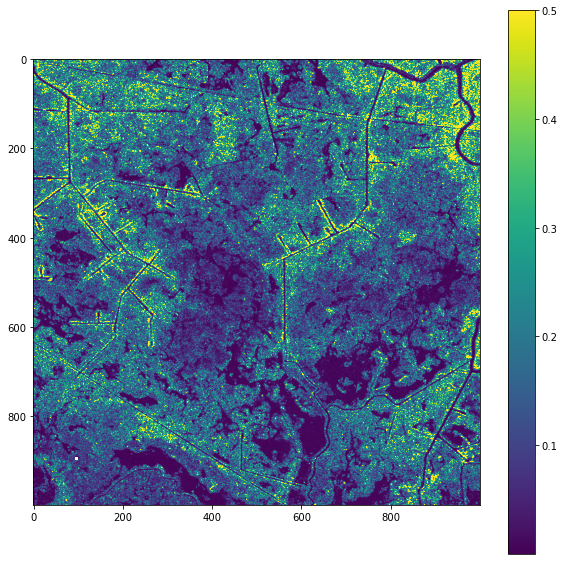

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(X, vmax=.5)
plt.colorbar()

# Spatial Denoising on the subset.

We first get the ENL ($L$) using the same procedure from an earlier notebook. Then, we apply the spatial denoising to the subset using a hand-selected weight parameter.

In [13]:
# L = 2 # We determine this from the previous notebook

enl_mask = get_enl_mask(X, db_min=-13)
enl_img = get_enl_img(X, 31, enl_max=20, mask=enl_mask)
L = round(get_enl_mode(enl_img))
L

2

The regularizer parameter is given as follows:

$$
X_d = \arg\min_{X}  \mathcal R(X) + \lambda \cdot P(X | X_0)
$$

where $X_0$ is the original image and $X_d$ is the final despeckled image. $\mathcal R$ is the regularizer i.e. TV or BM3D. The larger $\lambda$, the more weight is given to the "fidelity" or "MLE" term. The smaller $\lambda$ yields more "regularized" (or smoothed images according to the prior). Here, $\lambda$ is the `weight` term in the dictionary below. Again, the above is a highly simplified description and we recommend looking at [3] from above for the details as they relate to SAR.

For the TV implementation in `skimage`, $\lambda$ is $2 \cdot$ `weight` because the model is written as $|\nabla X|_1 + \lambda/2 || X - X_0||_2^2$ for an easier computation of the derivative. Note the $P(X|X_0)$ term is the $|| X - X_0||_2^2$ and more details of this can be found in [1].

We now test the model on the above subset. Adjust the weight to determine

In [14]:
if REGULARIZER == 'tv':
    regularizer_dict = {
                         'weight': 1
                        }
    
elif REGULARIZER == 'bm3d':
    regularizer_dict = {
                         'weight': .1
                        }
else:
    pass

In [15]:
X_den, res_list = admm_spatial_denoise(X_filled,
                                       L,
                                       REGULARIZER,
                                       regularizer_dict, 
                                       max_admm_iterations=10,
                                       newton_iterations=3
                                       )

admm_iterations: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


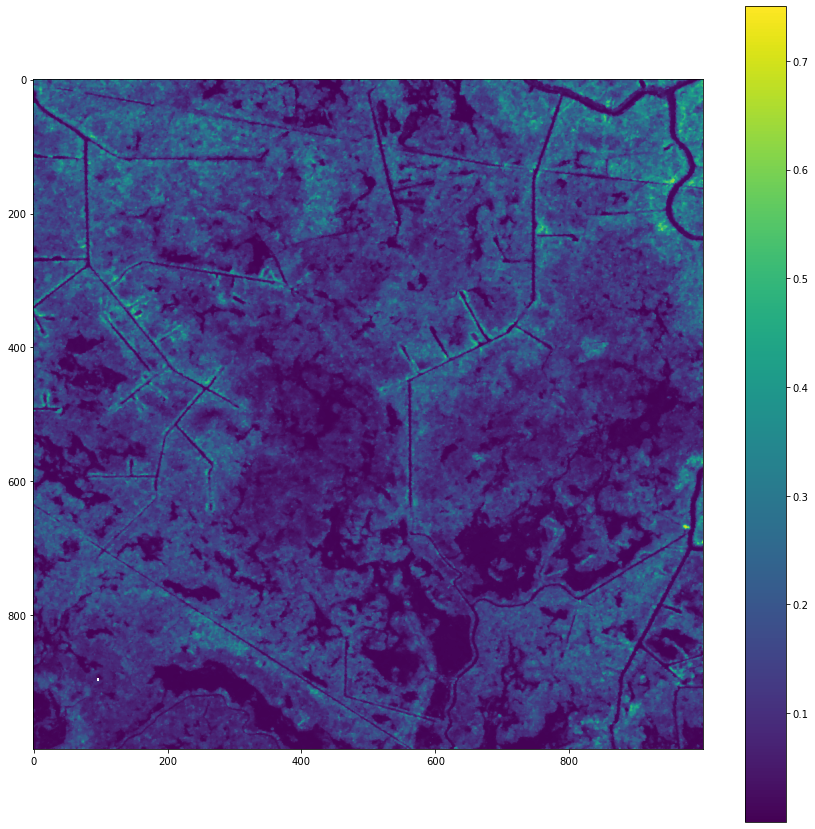

In [16]:
plt.figure(figsize=(15, 15))
X_den[np.isnan(X)] = np.nan
plt.imshow(X_den, vmax=.75)
plt.colorbar()

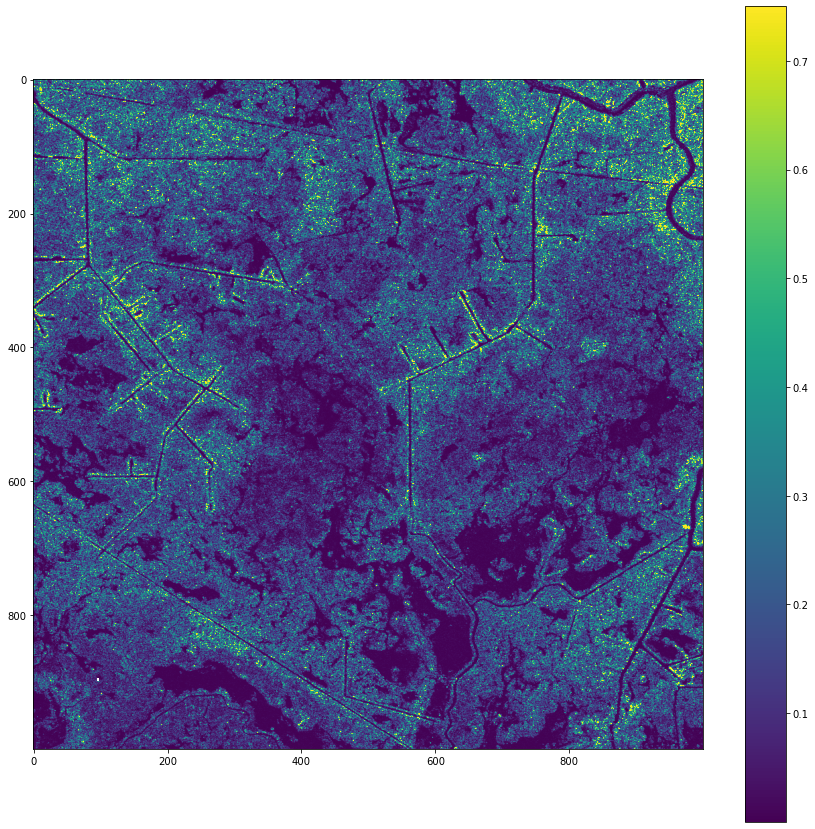

In [17]:
plt.figure(figsize=(15, 15))
plt.imshow(X, vmax=.75)
plt.colorbar()

Text(0.5, 0, 'ADMM Iterations')

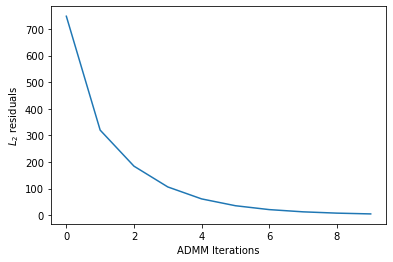

In [18]:
n = len(res_list)
plt.plot(np.arange(n), res_list)
plt.ylabel('$L_2$ residuals')
plt.xlabel('ADMM Iterations')

# Denoise all and Save to file

We now apply the spatial de-speckling from above to the full image extent and to all polarizations. We select the weight parameter the same as we did above.

In [19]:
hh_names = list(map(lambda x: x.name, hh_paths))
hv_names = list(map(lambda x: x.name, hv_paths))
vv_names = list(map(lambda x: x.name, vv_paths))

In [20]:
mask = np.isnan(hv_ts[0])

In [21]:
def denoise_and_write_one(img, file_name, pol, weight):
    
    regularizer_dict = {
                         'weight': weight
                        }
    
    denoised_img, _ = admm_spatial_denoise(img,
                                           L,
                                           REGULARIZER,
                                           regularizer_dict, 
                                           max_admm_iterations=10,
                                           newton_iterations=3
                                           )
    
    denoised_img[mask] = np.nan
    
    
    dest_dir = Path(f'{str(SPATIAL_DESPECKLE_DIR)}')/f'weight_{weight:1.2f}'/pol
    dest_dir.mkdir(exist_ok=True, parents=True)
    
    dest_path = dest_dir/file_name.replace('.tif', f'_{REGULARIZER}_{weight:1.2f}.tif')
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(denoised_img, 1)
    return dest_path

In [22]:
weight = 1
list(starmap(denoise_and_write_one, zip(tqdm(hh_ts_nn_fill), hh_names, ['hh'] * n, [weight] * n)))
list(starmap(denoise_and_write_one, zip(tqdm(hv_ts_nn_fill), hv_names, ['hv'] * n, [weight] * n)))
list(starmap(denoise_and_write_one, zip(tqdm(vv_ts_nn_fill), vv_names, ['vv'] * n, [weight] * n)))

admm_iterations:  40%|████      | 4/10 [00:29<00:44,  7.37s/it]


admm_iterations:  90%|█████████ | 9/10 [01:07<00:07,  7.78s/it]


100%|██████████| 7/7 [09:32<00:00, 81.83s/it]


[PosixPath('out/uavsar_waxlake_tv/spatially_despeckled/weight_1.00/vv/uavsar_waxlake_vv_RTC_20190620_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/spatially_despeckled/weight_1.00/vv/uavsar_waxlake_vv_RTC_20190701_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/spatially_despeckled/weight_1.00/vv/uavsar_waxlake_vv_RTC_20190716_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/spatially_despeckled/weight_1.00/vv/uavsar_waxlake_vv_RTC_20190725_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/spatially_despeckled/weight_1.00/vv/uavsar_waxlake_vv_RTC_20190812_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/spatially_despeckled/weight_1.00/vv/uavsar_waxlake_vv_RTC_20190923_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/spatially_despeckled/weight_1.00/vv/uavsar_waxlake_vv_RTC_20190930_tv_1.00.tif')]